In [1]:
import numpy as np
from libs.lfgenerator import TwoPart, Exponential, Shift, LorenzRandFGenerator
import matplotlib.pyplot as plt
from libs.seq2seq_model import LinearRNNModel, RNNModel

In [2]:
g=np.array([1,2,3])
h=np.array([5,4,6])

l = np.convolve(np.hstack((g[1:], g)),h, 'valid')
r = np.fft.ifft(np.fft.fft(g)*np.fft.fft(h))


In [3]:
def get_rho(x,y):
    length = x.shape[1]
    dim=x.shape[2]
    rho = []

    for j in range(dim):
        x_j = x[:,:,j]
        y_j = y[:,:,0]
        X = np.fft.fft(x_j, axis=1)
        Y = np.fft.fft(y_j, axis=1)
        Rho = []
        for i in range(length):
            r = np.linalg.lstsq(X[:,[i]],Y[:,[i]])[0].item()
            # r = ((X[:,[i]].T@Y[:,[i]]) / (X[:,[i]].T @ X[:,[i]]))[0,0]
            Rho.append(r)
        Rho = np.array(Rho)
        Rho = np.fft.ifft(Rho)
        rho.append(Rho)
    return np.array(rho)

In [4]:
def get_rho_lstsq(x,y, end_point=False, ydim=0):
    path_length = x.shape[1]
    data_num = x.shape[0]
    dim=x.shape[2]
    rho = []

    
    if not end_point:
        X = []
        Y = []
        for i in range(path_length):
            Y.append(y[:,i,ydim][:,None])
        Y = np.vstack(Y)

        for i in range(1, path_length+1):
            X.append(np.hstack([np.zeros((data_num,path_length*dim-i*dim)), x[:,:i,:].reshape(data_num,i*dim)]))
        X = np.vstack(X)
    else:
        X=x.reshape(data_num,path_length*dim)
        Y=y[:,:,0]

    # r = np.linalg.lstsq(X, Y)[0]
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression(n_jobs=6).fit(X, Y)
    rho = reg.coef_

    rho = rho.reshape(path_length, dim)
    return np.flip(rho)

In [5]:
path_length = 100
data_num=1
x,y = TwoPart({'centers': [[1.5, 4]],'sigmas':[[4, 4]],'path_len':path_length,'data_num':data_num}).generate()
# x,y = Exponential({'lambda':[0.5],'path_len':path_length,'data_num':10000}).generate()
# x,y = Shift({'input_dim':2, 'shift': [2,5], 'data_num':data_num, 'path_len':path_length}).generate()

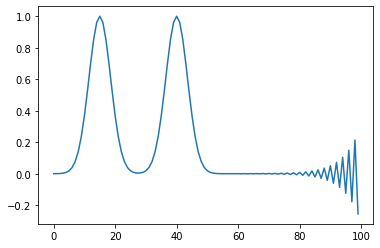

In [6]:
plt.plot(get_rho_lstsq(x,y, end_point=False)[:,0])

TCW dataset

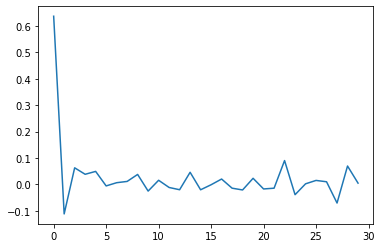

In [7]:
from dataprepare_tcw.tcw_generator import dataset_generator
data = np.load("dataprepare_tcw/tcw_1980_2022.npy")
train, test = dataset_generator(
        data, length=100, train_test_ratio=0.7, sliding_window=True
    )
T = 30
x = train[:5000, :T, :]
y = train[:5000, [T+1], :]
plt.plot(get_rho_lstsq(x,y, end_point=True)[:, 0])

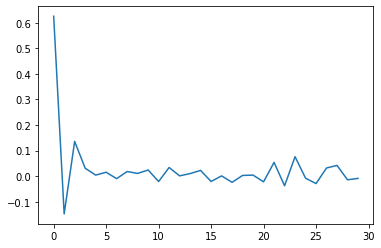

In [8]:
x = train[5000:10000, :T, :]
y = train[5000:10000, [T+1], :]
plt.plot(get_rho_lstsq(x,y, end_point=True)[:, 0])

cyl_cfd

In [9]:
points = []
Re = 40
for i in range(6):
    points.append(np.load(f"cyl_cfd/Re{Re}/p{i+1}.npy"))

In [10]:
from sklearn.preprocessing import normalize

p0, _ = dataset_generator(
        points[0], length=100, train_test_ratio=1, sliding_window=True
    )
p0 = p0[:,:,1:,0]

p0 = (p0-p0.min(axis=0))/(p0.max(axis=0)-p0.min(axis=0))

np.random.shuffle(p0)

p1, _ = dataset_generator(
        points[1], length=100, train_test_ratio=1, sliding_window=True
    )
p1 = p1[:,:,1:,0]

p1 = (p1-p1.min(axis=0))/(p1.max(axis=0)-p1.min(axis=0))

np.random.shuffle(p1)

In [11]:
def draw_with_offset(offset):
    r = [get_rho_lstsq(p0[offset:offset+8000],p1[offset:offset+8000],ydim=i) for i in range(3)]
    fig, ax = plt.subplots(3, 3, figsize=(8, 8))
    index = ['u', 'v', 'p']
    for i in range(3):
        for j in range(3):
            ax[i,j].plot(r[i][:,j])
            ax[i,j].title.set_text(f'{index[i]} -- {index[j]}')
            # ax[i,j].xlim([0,1])
            ax[i,j].set_ylim([-1,1])

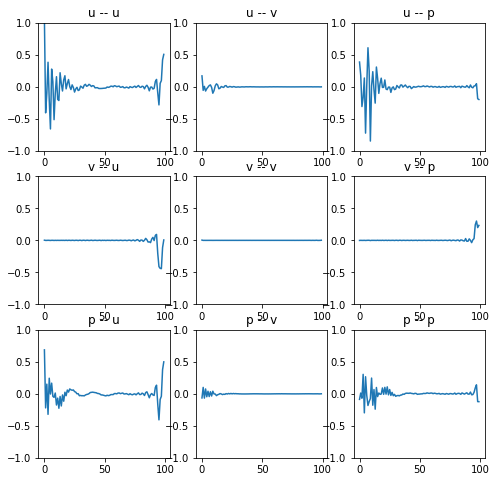

In [12]:
draw_with_offset(0)

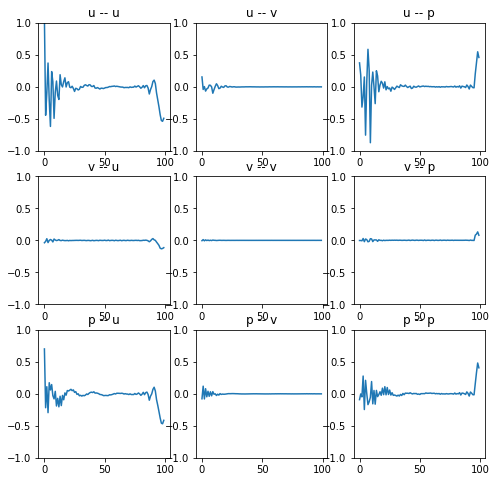

In [13]:
draw_with_offset(8000)

In [15]:
import pytorch_lightning as pl
import torch 

model = RNNModel.load_from_checkpoint("runs/train_rnn/version_0/checkpoints/epoch=35-valid_loss=1.53e-05.ckpt")

In [36]:
inputs = torch.ones(1, 128 * 4, 1, dtype=torch.float32) * 0.1
outputs = model(inputs)
max_outputs, _ = torch.max(outputs, dim=0)
max_outputs = max_outputs.detach().numpy()
outputs_memory = np.squeeze(
        np.abs(max_outputs[2:] - 2 * max_outputs[1:-1] + max_outputs[:-2])
    )  # (T-2) *D
outputs_memory = np.squeeze(
        np.abs(max_outputs[1:] - max_outputs[:-1])
    )  # (T-2) *D

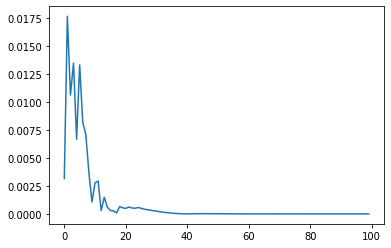

In [37]:
plt.plot(outputs_memory[:100], label="model memory")

In [38]:
x,_ = LorenzRandFGenerator({'n_init':512, 'K':1, 'J':10,'path_len':128, 'only_terminal':False, 'data_num':25600}).generate()

In [39]:
y = model(torch.tensor(x, dtype=torch.float32))

In [40]:
r = get_rho_lstsq(x,y.detach().numpy(), end_point=False)[:, 0]

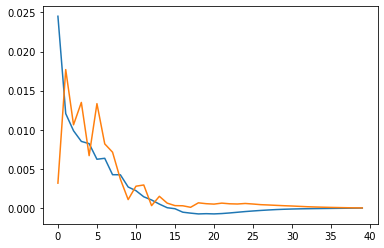

In [41]:
plt.plot(r[:40])
plt.plot(outputs_memory[:40], label="model memory")

In [ ]:
r(0) x(t-0) + ... +r(tau)x(t-tau)